# Burgers Equation

$$u_t+uu_x=0.1u_{xx}$$

In [1]:
import os
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import torch
import tensorflow as tf

import csv
from torch.autograd import grad
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ExponentialLR
from pylab import figure, text, scatter, show
from pdefind import *
#from pdefind.network import build_library
from Model_Identification.PDE_Equation import pde_matrix_mul, sparse_coeff, normalized_xi_threshold, pde_Recover
from Model_Identification.build_Library import construct_Dictonary
 


## Data Setup

u shape (256, 101)
x shape (256,)
t shape (101,)


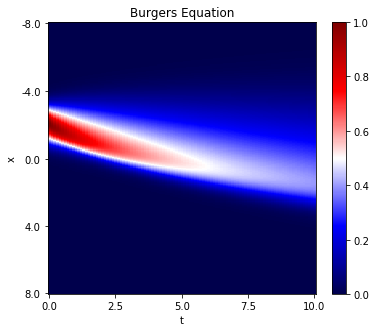

In [2]:
data = sio.loadmat(os.path.join(os.getcwd(), "../data", "burgers.mat"))
u = data["usol"]
x = data["x"][0]
t = np.squeeze(data["t"], axis=1)

print("u shape", u.shape)
print("x shape", x.shape)
print("t shape", t.shape)

im = plt.imshow(u.real, cmap="seismic", aspect=0.4)
plt.colorbar(im)
plt.title("Burgers Equation")
plt.xlabel("t")
plt.ylabel("x")


xpos  = np.arange(len(t), step=25)
ypos  = np.where(x%4==0)[0].tolist()
ytick = x[ypos].tolist()
ypos  += [len(x)-1]
ytick += [8.0]

plt.xticks(xpos, t[xpos])
plt.yticks(ypos, ytick)
plt.gcf().set_size_inches(6,5)
plt.show()

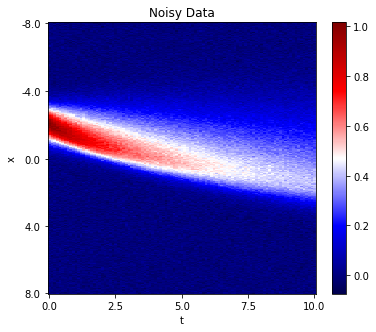

In [3]:
# Add noise
noise_level = 0.1
u = u.real + noise_level*np.std(u.real)*np.random.randn(u.shape[0],u.shape[1])

im = plt.imshow(u.real, cmap="seismic", aspect=0.4)
plt.colorbar(im)
plt.title("Noisy Data")
plt.xlabel("t")
plt.ylabel("x")

plt.xticks(xpos, t[xpos])
plt.yticks(ypos, ytick)
plt.gcf().set_size_inches(6,5)
plt.show()

In [4]:
# Prepare Training Data
xx, tt = np.meshgrid(x,t)
X = np.vstack([xx.ravel(), tt.ravel()]).T
print("X shape", X.shape)
print(X)

X shape (25856, 2)
[[-8.      0.    ]
 [-7.9375  0.    ]
 [-7.875   0.    ]
 ...
 [ 7.8125 10.    ]
 [ 7.875  10.    ]
 [ 7.9375 10.    ]]


y shape (25856, 1)


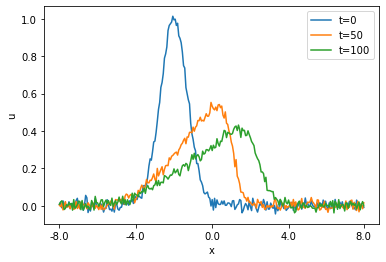

In [5]:
y = np.zeros((u.size, 1), dtype=np.float)
for i,_x in enumerate(u.real.T):
    y[i*len(x):(i+1)*len(x)] = _x.reshape(len(x),1)
    
print("y shape", y.shape)

plt.plot(y[:256], label="t=0")
plt.plot(y[50*256:51*256], label="t=50")
plt.plot(y[100*256:101*256], label="t=100")
plt.xlabel("x")
plt.ylabel("u")
plt.xticks(ypos, ytick)
plt.legend()
plt.show()

X_train shape torch.Size([1000, 2])
y_train shape torch.Size([1000, 1])
X shape (25856, 2)
y shape (25856, 1)


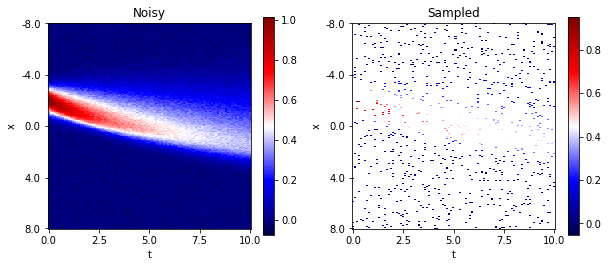

In [6]:
idxs = np.random.choice(y.size, 1000, replace=False)

X_train = torch.tensor(X[idxs], dtype=torch.float32, requires_grad=True)
y_train = torch.tensor(y[idxs], dtype=torch.float32)
print("X_train shape", X_train.shape)
print("y_train shape", y_train.shape)
print("X shape", X.shape)
print("y shape", y.shape)

plt.subplot(1,2,1)
im = plt.imshow(u, cmap="seismic", aspect=0.4)
plt.colorbar(im)
plt.xlabel("t")
plt.ylabel("x")
plt.title("Noisy")

plt.xticks(xpos, t[xpos])
plt.yticks(ypos, ytick)

usamp = np.full(y.shape,np.nan)
usamp[idxs] = y[idxs]
usamp = usamp.reshape(u.T.shape).T

plt.subplot(1,2,2)
im = plt.imshow(usamp, cmap="seismic", aspect=.4)
plt.colorbar(im)
plt.xlabel("t")
plt.ylabel("x")
plt.title("Sampled")

plt.xticks(xpos, t[xpos])
plt.yticks(ypos, ytick)

plt.gcf().set_size_inches(10,4)
plt.show()

In [7]:
# Setup Network
net = PINN(sizes=[2,20,20,20,20,20,1], activation=torch.nn.Tanh())
print(net)

PINN(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): Tanh()
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Tanh()
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): Tanh()
    (6): Linear(in_features=20, out_features=20, bias=True)
    (7): Tanh()
    (8): Linear(in_features=20, out_features=20, bias=True)
    (9): Tanh()
    (10): Linear(in_features=20, out_features=1, bias=True)
  )
)


In [8]:
polynm = ['1', 'u', 'uˆ2']
spa_der = ['1', 'u_{x}', 'u_{xx}']
library_coeffs = pde_matrix_mul(polynm, spa_der)
print('library_coeffs:', library_coeffs)

tot_items = len(library_coeffs)
print('tot_items:', tot_items)

mask = torch.ones(tot_items, 1)
epochs = 10000
#xi = nn.Parameter(torch.randn((1, 1), requires_grad=True, device="cpu", dtype=torch.float32))
xi = nn.Parameter(torch.randn((tot_items, 1), requires_grad=True, device="cpu", dtype=torch.float32))
#xi = torch.tensor([[0.1], [-1]])
#print(xi)
#params = [{'params': net.parameters(), 'lr': 1e-3}]
params = [{'params': net.parameters(), 'lr': 3e-3}, {'params': xi, 'lr': 3e-2}]

optimizer = Adam(params)
scheduler = ExponentialLR(optimizer, .9998)

#f2 = open("../Results/Result.txt", "w+", encoding="utf-8")
#f2 = open("../Results/Result.csv", "w+")
#f1 = open("result.txt", 'w', encoding="utf-8")

#f1 = open("../Results/xi1.txt", "w+", encoding="utf-8")
#f2 = open("../Results/xi2.txt", "w+", encoding="utf-8")


library_coeffs: ['1', 'u_{x}', 'u_{xx}', 'u', 'uu_{x}', 'uu_{xx}', 'uˆ2', 'uˆ2u_{x}', 'uˆ2u_{xx}']
tot_items: 9


In [9]:
def denoised_NeuralNet(features, label, mask, poly_order, deriv_order):
    lamb   = 0
    tolerance = 1e-6
    mask = torch.ones(tot_items, 1)
    print('xi', xi)
    print('mask:', mask.shape)
    lambd  = 1e-6
    
    L1_loss = []
    MSE_loss = []
    Reg_loss = []
    Total_loss = []

    
    for epoch in range(epochs):
        optimizer.zero_grad()
        uhat = net(features)
    
        if epoch == 1000:
            lamb = 1
               
        dudt, theta = construct_Dictonary(features, uhat, poly_order=2, deriv_order=2)
        #print('dudt:', dudt.shape)
        dudt_norm = torch.norm(dudt, dim=0)
        #print('dudt_norm:', dudt_norm.shape)
    
    
        theta_scaling = (torch.norm(theta, dim=0))
        #print('theta_scaling:', theta_scaling.shape)
        #Returns a new tensor with a dimension of size one inserted at the specified position. from 9 it will be 9,1
        theta_norm = torch.unsqueeze(theta_scaling, dim = 1) 
        #print('theta_norm:', theta_norm.shape)
        xi_normalized = xi * (theta_norm / dudt_norm) 
        L1 = lambd * torch.sum(torch.abs(xi_normalized[1:, :]))
        
        l_u   = nn.MSELoss()(uhat, label)
        l_reg = lamb * torch.mean((dudt - theta @ xi)**2)
        #l_reg = torch.mean((dudt - theta @ xi)**2)

        loss = l_u + l_reg + L1
        #print('loss', loss)
        
      
        L1_loss.append(L1.item())
        MSE_loss.append(l_u.item())
        Reg_loss.append(l_reg.item())
        Total_loss.append(loss.item())
        
        losses = {"L1_loss": L1_loss,
                  "MSE_loss": MSE_loss,
                  "Reg_loss": Reg_loss,
                  "Total_loss": Total_loss}
    
        
        gradient_loss = torch.max(torch.abs(grad(outputs=loss, inputs=xi, 
              grad_outputs=torch.ones_like(loss), create_graph=True)[0]) / (theta_norm / dudt_norm))
        


        loss.backward(retain_graph=True)
        optimizer.step()
    
        #print("epoch {}/{}, loss={:.10f}".format(epoch+1, epochs, loss.item()), end="\r")
        
        if epoch % 1000 == 0:
            print('loss:', epoch, loss)
            #if gradient_loss < tolerance:
                #print('Optimizer converged.')
                #break
 
    #print('xi_normalized:', xi_normalized)
    xi_list = sparse_coeff(mask, xi.detach().numpy())
    xi_normalized = sparse_coeff(mask, xi_normalized.detach().numpy())
    print('xi_normalized:', xi_normalized)
                   
    return xi_list, xi_normalized, losses

In [10]:
def model_identification(features, label, mask, poly_order, deriv_order):
   
    xi_list, xi_normalized, losses = denoised_NeuralNet(features, label, mask, poly_order=2, deriv_order=2)
    sparsity = normalized_xi_threshold( xi_normalized, mode='auto')
    print('sparsity:', sparsity)
    
  
    xi_thresholded = np.expand_dims(xi_list[sparsity], axis=1) 
    print('xi_thresholded:', xi_thresholded)
    
    np.savetxt('xi1.txt', xi_thresholded[0], fmt="%.8f")
    np.savetxt('xi2.txt', xi_thresholded[1], fmt="%.8f")
    # Calculate Error in xi
    xi1_error = np.subtract(np.array([0.10000]),np.abs(xi_thresholded[0]))
    print('xi1_error', xi1_error)
    xi2_error = np.subtract(np.array([1.00000]),np.abs(xi_thresholded[1]))
    print('xi2_error', xi2_error)
    print('Coefficient xi:')
    xi_updated = sparse_coeff(sparsity, xi_thresholded)
    print(xi_updated)
    
    print('Finished')   
            
    return xi_updated, losses

In [11]:

uhat = net(X_train)
xi_updated, losses= model_identification(X_train, y_train, mask, poly_order=2, deriv_order=2)

xi Parameter containing:
tensor([[ 0.5233],
        [-0.3926],
        [-0.5075],
        [ 2.8306],
        [-0.5318],
        [ 0.5939],
        [-0.3587],
        [ 1.5545],
        [-0.1460]], requires_grad=True)
mask: torch.Size([9, 1])
loss: 0 tensor(0.1293, grad_fn=<AddBackward0>)
loss: 1000 tensor(0.2755, grad_fn=<AddBackward0>)
loss: 2000 tensor(0.0004, grad_fn=<AddBackward0>)
loss: 3000 tensor(0.0003, grad_fn=<AddBackward0>)
loss: 4000 tensor(0.0003, grad_fn=<AddBackward0>)
loss: 5000 tensor(0.0003, grad_fn=<AddBackward0>)
loss: 6000 tensor(0.0003, grad_fn=<AddBackward0>)
loss: 7000 tensor(0.0003, grad_fn=<AddBackward0>)
loss: 8000 tensor(0.0003, grad_fn=<AddBackward0>)
loss: 9000 tensor(0.0003, grad_fn=<AddBackward0>)
xi_normalized: [[-1.29376631e-02]
 [-8.52306548e-04]
 [ 4.69196975e-01]
 [-7.96991109e-04]
 [-9.38167036e-01]
 [ 1.05121895e-03]
 [-6.06816821e-03]
 [-9.61531699e-02]
 [-6.10825643e-02]]
sparsity: [[False]
 [False]
 [ True]
 [False]
 [ True]
 [False]
 [False]
 

In [12]:
print(uhat.shape)
pde_Recover(xi_updated, library_coeffs, equation_form='u_t')

torch.Size([1000, 1])
Burger equation:


'u_t = 0.1078u_{xx} - 0.9238uu_{x}'

uhat.shape: torch.Size([25856, 1])
MSE loss 0.00033589181839488447


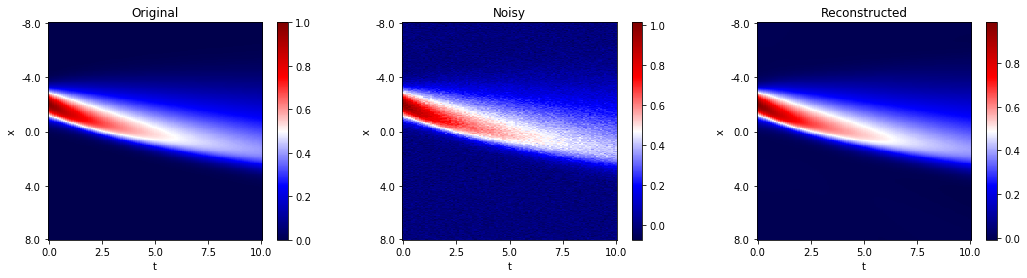

In [13]:
uhat = net(torch.FloatTensor(X))
print('uhat.shape:', uhat.shape)
print("MSE loss", nn.MSELoss()(uhat, torch.FloatTensor(y)).item())

uhat = uhat.data.reshape(u.T.shape)

plt.subplot(1,3,1)
im = plt.imshow(data["usol"].real, cmap="seismic", aspect=0.4)
plt.colorbar(im)
plt.xlabel("t")
plt.ylabel("x")
plt.title("Original")

plt.xticks(xpos, t[xpos])
plt.yticks(ypos, ytick)

plt.subplot(1,3,2)
im = plt.imshow(u, cmap="seismic", aspect=0.4)
plt.colorbar(im)
plt.xlabel("t")
plt.ylabel("x")
plt.title("Noisy")

plt.xticks(xpos, t[xpos])
plt.yticks(ypos, ytick)

plt.subplot(1,3,3)
im = plt.imshow(uhat.numpy().T, cmap="seismic", aspect=.4)
plt.colorbar(im)
plt.xlabel("t")
plt.ylabel("x")
plt.title("Reconstructed")

plt.xticks(xpos, t[xpos])
plt.yticks(ypos, ytick)

plt.gcf().set_size_inches(18,4)
plt.show()


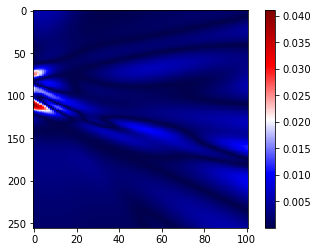

In [14]:
plt.imshow(np.abs(uhat.numpy().T.data - data["usol"].real), cmap="seismic", aspect=.4)
plt.colorbar()
plt.show()

Text(0.5, 1.0, 'Sampled')

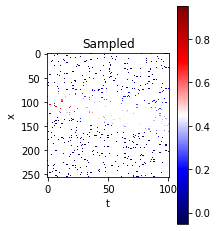

In [15]:
usamp = np.full(y.shape,np.nan)
usamp[idxs] = y_train
usamp = usamp.reshape(u.T.shape).T

plt.subplot(1,2,2)
im = plt.imshow(usamp, cmap="seismic", aspect=.4)
plt.colorbar(im)
plt.xlabel("t")
plt.ylabel("x")
plt.title("Sampled")

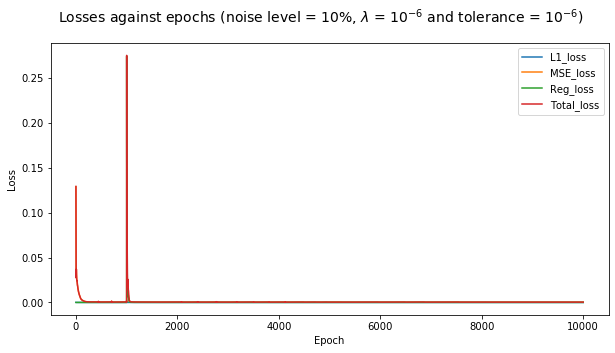

In [16]:
#_, _, losses = denoised_NeuralNet(X_train, y_train, mask, poly_order=2, deriv_order=2)
Total_loss = losses['Total_loss']
#print('Total Loss:', Total_loss)
L1_loss = losses['L1_loss']
MSE_loss = losses['MSE_loss']
Reg_loss = losses['Reg_loss']

plt.figure(figsize=(10, 5))
#plt.title('Losses against epochs (noise level = 10%, $\lambda$ = $10^{\mathrm{-6}}$ and tolerance = $10^{\mathrm{-6}}$)', fontsize=14)
plt.suptitle('Losses against epochs (noise level = 10%, $\lambda$ = $10^{\mathrm{-6}}$ and tolerance = $10^{\mathrm{-6}}$)', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(L1_loss, label="L1_loss")
plt.plot(MSE_loss, label="MSE_loss")
plt.plot(Reg_loss, label="Reg_loss")
plt.plot(Total_loss, label="Total_loss")
plt.legend(loc='upper right')
plt.show()

